![skillfactory_logo](https://raw.githubusercontent.com/anna-kostyakova/SkillFactory_Projects/main/module%205/assets/cars.png)


# <center> Прогнозирование стоимости автомобиля по характеристикам </center>

## Задача - создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. 

### Описание признаков

- bodyType - тип кузова           
- brand - марка автомобиля               
- car_url - адрес страницы с объявлением              
- color - цвет автомобиля                 
- complectation_dict - словарь с параметрами комплектации авто
- description - описание автомобиля      
- engineDisplacement - объем двигателя    
- enginePower - мощность двигателя       
- equipment_dict - словарь оснащения авто      
- fuelType - тип топлива             
- image - изображение                
- mileage - пробег               
- modelDate - дата выпуска модели             
- model_info - информация о модели
- model_name - название модели            
- name - имя                 
- numberOfDoors - кол-во дверей       
- parsing_unixtime - когда был произведен парсинг данных      
- priceCurrency - валюта        
- productionDate - год производства     
- sell_id               
- super_gen - словарь с дополинтельной информацией             
- vehicleConfiguration - конфигурация транспортного средства  
- vehicleTransmission - трансмиссия   
- vendor - страна-изготовитель               
- Владельцы - кол-во владельцев      
- Владение - период владения              
- ПТС                  
- Привод                
- Руль                  
- Состояние             
- Таможня          

## Import

In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
from pandas import Series
import numpy as np
from numpy import mean
import json
import collections

from datetime import datetime, date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics.cluster import completeness_score, v_measure_score

from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import randint
import statsmodels.api as sm

from imblearn.pipeline import Pipeline

from math import log as log
import os

from itertools import combinations
from scipy.stats import ttest_ind

import re

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [5]:
RANDOM_SEED = 42

## Helpers

In [6]:
# Класс для обработки признака времени владения автомобилем.

class OwnershipPeriod():
    def __init__(self):
        self.pattern = re.compile('((\d+) (года|год|лет)){0,1}( и ){0,1}((\d+) (месяц)){0,1}')
        
    def get_months_from_ownership_period(self, x):
        '''Функция для подсчета кол-ва месяцев владения автомобилем, осуществляется через 
        преобразование кол-ва лет и месяцев в кол-во месяцев.'''
        search_res = self.pattern.search(str(x))

        years = 0
        months = 0

        if search_res.group(2):
            years = int(search_res.group(2))
        if search_res.group(6):
            months = int(search_res.group(6))

        return years*12 + months

In [7]:
def profile_report(df):
    '''Функция для вызова профайл-отчета о датафрейме'''
    
    if df is None:
        raise TypeError(nameof(df))

    profile = df.profile_report(
        title='Car Price prediction',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True},
            'spearman': {'calculate': True},
            'kendall': {'calculate': True},
            'phi_k': {'calculate': True},
            'cramers': {'calculate': True},
        },
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat': {'n_obs': 10}
        }
    )

    return profile

In [8]:
def asfloat(x, zero_if_none=False):
    '''Функция для перевода значения в float.'''
    if x is None or x == '':
        if zero_if_none:
            return 0
        else:
            return None
    else:
        return float(x)    

In [9]:
def asdict(x):
    '''Функция для замены значений в словаре.'''
    if type(x) != str:
        return None
    
    return eval(x.replace('true', 'True').replace('false', 'False'))

In [10]:
def labeling(col):
    '''Функция для кодирования признаков.'''
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [11]:
def get_log(df, col):
    '''Функция для логарифмирования признака'''
    
    return df[col].apply(lambda x: np.log(x + 1))

In [12]:
# Класс для исследования числовых признаков
class NumericInspector():
    def __init__(self, df):
        self.df = df

    def _prepare_series(self, column, log):
        return self.df[column] if log == False else get_log(self.df, column)

    def _show_plots(self, df_series, title, size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig = sm.qqplot(df_series, fit=True, line='45', ax=ax1)

        fig.suptitle(title, fontsize=20)

        ax2.hist(df_series, bins=20, histtype='bar', align='mid', rwidth=0.8)

        ax3.boxplot(df_series, vert=False)

        ax1.set_title('QQ-plot')
        ax2.set_title('Histogram')
        ax3.set_title('Boxplot')
        
        plt.show()

    def _boundaries(self, df_series):
        q1 = df_series.quantile(q=0.25, interpolation="midpoint")
        q3 = df_series.quantile(q=0.75, interpolation="midpoint")
        IQR = q3 - q1

        return q1 - 1.5*IQR, q3 + 1.5*IQR, q1, q3, IQR

    def _outliers(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)

        return len(df_series[df_series < minb]) + len(df_series[df_series > maxb])

    def _display_result_info(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)
        
        display(HTML(
            f'''
                <div style="text-align: center; margin-bottom: 20px;"> 
                    --- <span style="font-weight: bold;">q1: </span>
                    {np.round(q1, 2)},
                    <span style="font-weight: bold;">q3: </span>
                    {np.round(q3, 2)},
                    <span style="font-weight: bold;">IQR: </span>
                    {np.round(IQR, 2)},
                    <span style="font-weight: bold;">Boundaries: </span>
                    {np.round((minb, maxb), 2)}, 
                    <span style="font-weight: bold;">Outliers: </span>
                    {self._outliers(df_series)} --- 
                </div>
            '''))

    def inspect(self, column, size=5, with_log=True, title=None, title_for_log=None):
        # дефолтное отображение
        title_wl = title if title is not None else f"Inspection for '{column}' without 'log'"
        df_series = self._prepare_series(column, log=False)
        self._show_plots(df_series, title_wl, size)
        self._display_result_info(df_series)

        if with_log:
            # с логарифмированием
            title_fl = title_for_log if title_for_log is not None else f"Inspection for '{column}' with 'log'"
            try:
                df_series = self._prepare_series(column, log=True)
                self._show_plots(df_series, title_fl, size)
                self._display_result_info(df_series)
            except:
                plt.close()
                display(HTML(
                    f'''
                    <div style="text-align: center; margin-bottom: 22px;">
                        <span style="font-size: 20px; font-weight: bold;">Логарифмирование признака не удалось! :( </span>
                    </div>
                    '''))

        display(HTML('<hr style="width:90%; height:2px; border-width:0; color:gray; background-color:gray; margin-bottom: 30px;">'))

In [13]:
def mape(y_true, y_pred):
    '''Функция для определения метрики'''
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Data

В рамках задания были предоставлены тестовые данные. Для получения обучающей выборки был произведен парсинг данных с сайта auto.ru. На github представлен отдельный ноутбук с кодом для парсинга. В рамках ноутбука на Kaggle загружается готовый датасет без указания кода для парсинга.

In [14]:
train = pd.read_csv('parsed_data.csv')
test = pd.read_csv('test.csv')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52055 entries, 0 to 52054
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              52055 non-null  object 
 1   brand                 52055 non-null  object 
 2   car_url               52055 non-null  object 
 3   color                 52055 non-null  object 
 4   complectation_dict    10058 non-null  object 
 5   description           50321 non-null  object 
 6   engineDisplacement    52055 non-null  object 
 7   enginePower           52055 non-null  object 
 8   equipment_dict        52055 non-null  object 
 9   fuelType              52055 non-null  object 
 10  image                 0 non-null      float64
 11  mileage               52055 non-null  int64  
 12  modelDate             52055 non-null  int64  
 13  model_info            52055 non-null  object 
 14  model_name            52055 non-null  object 
 15  name               

In [16]:
train.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      41997
description              1734
engineDisplacement          0
enginePower                 0
equipment_dict              0
fuelType                    0
image                   52055
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                35436
ПТС                         2
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
price                       0
dtype: int

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [18]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

## Prepping data

Для корректной работы над данными и построения модели, необходимо провести первоначальную обработку имеющихся данных, чтобы наблюдения в тестовой и обучающей выборке были отражены одинаковым образом.

Посмотрим, есть ли у нас дубликаты в датасетах.

In [19]:
train['sell_id'].duplicated().sum()

0

In [20]:
test['sell_id'].duplicated().sum()

0

Объединим датасеты для дальнейшей обработки.

In [21]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

Проверим на дубликаты. Нет ли у нас в обучающей выборке наблюдения из тестовой, - иначе модель может работать не корректно.

In [22]:
data['sell_id'].duplicated(keep=False).sum()

3544

In [23]:
data[data.sell_id.duplicated(keep=False)].head(6)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sample,price
128,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,Состояние нового авто. (цена в автосалоне от 1...,1.4 LTR,150 N12,"{""engine-proof"":true,""glonass"":true,""asr"":true...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,13000,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (150 л.с.),5,1603226771,RUB,2020,1101109897,"{""id"":""20898379"",""displacement"":1395,""engine_t...",LIFTBACK MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 месяц,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
156,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,чёрный,"{""id"":""21404914"",""name"":""Hockey Edition"",""avai...","Новый автомобиль, приобретался в Автосалоне Fa...",2.0 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,138,2016,"{""code"":""KODIAQ"",""name"":""Kodiaq"",""ru_name"":""Ко...",KODIAQ,2.0d AMT (150 л.с.) 4WD,5,1603226880,RUB,2020,1101313442,"{""id"":""20839377"",""displacement"":1968,""engine_t...",ALLROAD_5_DOORS ROBOT 2.0,роботизированная,EUROPEAN,1 владелец,4 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN
226,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,бежевый,NaN,Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,1.4 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,8045,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 AMT (150 л.с.),5,1603227152,RUB,2019,1100210074,"{""id"":""20898391"",""displacement"":1395,""engine_t...",WAGON_5_DOORS ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
405,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серебристый,NaN,Продаю свою машину. Куплена новой в Минске. По...,1.8 LTR,160 N12,"{""cruise-control"":true,""esp"":true,""airbag-driv...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,249197,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,1.8 MT (160 л.с.) 4WD,5,1603227841,RUB,2013,1101303554,"{""id"":""20767690"",""displacement"":1798,""engine_t...",LIFTBACK MECHANICAL 1.8,механическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN
433,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"{""id"":""20803791"",""name"":""Ambition"",""available_...",Продаю автомобиль (производство Чехия) по прич...,1.4 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,138000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (150 л.с.),5,1603227943,RUB,2016,1101299678,"{""id"":""20642741"",""displacement"":1395,""engine_t...",WAGON_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 год и 2 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
537,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia_r...,синий,NaN,"Продаю свой автомобиль , в отличном состоянии ...",2.0 LTR,200 N12,"{""cruise-control"":true,""engine-proof"":true,""as...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,154000,2008,"{""code"":""OCTAVIA_RS"",""name"":""Octavia RS"",""ru_n...",OCTAVIA_RS,2.0 AMT (200 л.с.),5,1603228333,RUB,2012,1101186075,"{""id"":""5009158"",""displacement"":1984,""engine_ty...",LIFTBACK ROBOT 2.0,роботизированная,EUROPEAN,2 владельца,1 год и 1 месяц,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN


Такие наблюдения у нас есть. Удалим дубликаты пришедшие из обучающей выборки.

In [24]:
data = data.drop_duplicates(subset=['sell_id'], keep='first')

In [25]:
# Переимунуем колонки

data.rename(columns={
    'Владельцы': 'owners_number', 
    'Владение': 'ownership_period',
    'ПТС': 'pts', 
    'Привод': 'gear_type',
    'Руль': 'steering_wheel', 
    'Состояние': 'state', 
    'Таможня': 'custom_cleared'
}, inplace=True)

In [26]:
# Преобразуем значения в колонке steering_wheel

data['steering_wheel'] = data['steering_wheel'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

In [27]:
# Преобразуем значения в колонке pts

data['pts'] = data['pts'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

In [28]:
# Преобразуем значения в колонке bodyType

data['bodyType'] = data['bodyType'].apply(lambda x: x.split(' ')[0])

In [29]:
# Преобразуем значения в колонке engineDisplacement
# Заменим пустые значения на 0, так как, судя по данным, они все относятся к электрокарам

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: asfloat(x[:-4], zero_if_none=True)).astype('float32')

In [30]:
# Преобразуем значения в колонке enginePower

data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:-4])).astype('int32')

In [31]:
# Преобразуем значения в колонке owners_number

data['owners_number'] = data['owners_number'].apply(lambda x: int(x[0])).astype('int32')

In [32]:
# Преобразуем значения в колонке ownership_period - переведем все в кол-во месяцев

ownership_processor = OwnershipPeriod()
data['ownership_period'] = data['ownership_period'].apply(ownership_processor.get_months_from_ownership_period).astype('int32')

Далее преобразуем строковые величины в виде словарей в словари. Далее, возможно, возьмем оттуда информацию для улучшения точности модели. Из признака super_gen сразу возьмем значения расхода топлива и разгона.

In [33]:
# super_gen

data['super_gen'] = data['super_gen'].apply(lambda x: eval(x))

data['fuel_rate'] = data['super_gen'].apply(lambda x: x['fuel_rate'] if 'fuel_rate' in x.keys() else 0)
data['acceleration'] = data['super_gen'].apply(lambda x: x['acceleration'] if 'acceleration' in x.keys() else 0)

In [34]:
# equipment_dict

data['equipment_dict'] = data['equipment_dict'].apply(asdict)

In [35]:
# complectation_dict

data['complectation_dict'] = data['complectation_dict'].apply(asdict)

Удалим признаки, которые не несут для нас необходимой информации или дублируют то, что у нас уже представлено в других признаках.

In [36]:
data.drop(columns=[
    'name', 
    'model_info', 
    'image', 
    'vehicleConfiguration', 
    'car_url', 
    'parsing_unixtime',
    'priceCurrency', 
    'super_gen', 
    'state', 
    'custom_cleared'
], inplace=True)

In [37]:
# # Подготовим данные для осмотра в HTML формате, ссылка на данные будет ниже

# data_profile = profile_report(data)
# data_profile.to_file('output.html')

## Data Inspection

In [38]:
# По желанию, профайл можно посмотреть внутри ноутбука.

# pandas_profiling.ProfileReport(data)

#### Ссылка на профайл **[the dataset profile report](./output.html)**.

### На основании профайлинга можем видеть следующее:

1. В датасете представлено **25 признаков** (sample мы не учитываем, так как это искусственно созданный признак для последующего удобства при разделении данных на тестовую и обучающую выборки.
2. В объединенных данных представлено **84969 наблюдений.**
3. Признак **bodyType / brand / color** содержат много уникальных значений, без пропусков. Далее закодируем данные признаки с помощью label encoding. 
4. Признак **словаря комплектаций** содержит очень много пустых значений. Даже если мы вытащим оттуда какой-то из ключей, более половины датафрейма по этому ключу будут нулевыми. Поэтому, скорее всего, далее, этот признак будет удален.
5. Признак **description.** Данный признак далее будет удален. Возможно, будет проведена обработка признака (векторизация или создание бинарных колонок при наличии того или иного слова/выражения, которые могут быть полезны для модели).
6. Признак **объема двигателя** - имеет числовую природу. Есть нулевые значения, относящиеся к электрокарам. Попробуем создать отдельный признак принадлежности автомобиля к электрической. Распределение смещенное, попробуем логарифмирование. Пропусков нет. Также попробуем создать признак объема двигателя категориальный.
7. Признак **мощности двигателя / пробега.** Распределение, в принципе, нормальное, немного смещено, попробуем логарифмирование. Пропусков нет. Также попробуем отобразить признаки мощности / пробега двигателя в качестве категориальных.
8. Признак **equipment_dict.** Более 10% значений пропущено. Внутри самого словаря также есть большая разница в ключах. При необходимости обратимся еще к данному признаку. Но пока его не трогаем.
9. Признак **fuelType.** Нет пропусков, содержит пять категорий. Далее закодируем данный признак с помощью label encoding.
10. Признак **model_date / production_date.** Год выпуска модели / производства модели. Пропусков нет. В тестовой выборке присутствует автомобиль 1904 года - ретро. Поэтому считать его выбросом спорно. Распределение смещенное, попробуем логарифмирование.
11. Признак **model_name.** Пропусков нет. Далее закодируем данный признак с помощью label encoding.
12. Признак **кол-ва дверей.** С одной стороны это числовой признак - конкретно по штукам считаем двери. Однако невозможно дать оценку, что две двери лучше трех или пять дверей лучше четырех. Поэтому будем смотреть на него, как на категориальный и закодируем данный признак с помощью label encoding.
13. Признаки **трансмиссии / кол-во владельцев / привод** - категориальные, пропусков нет. Далее закодируем данные признаки с помощью label encoding.
14. Признак **vendor** - без пропусков. Далее закодируем данные признаки с помощью label encoding. 
15. Признак **времени владения.** Более 60% имеют нулевые значения - это связано с пропусками в данных. Теоретически невозможно, чтобы автомобиль б/у находился до этого во владении 0 месяцев. Попробуем выделить нулевые значения в отдельный признак - period_unknown, а нулевые значения в исходном признаке заменить на медианные. Экспериментально оценим, как это окажет влияние на модель или нет. И если да - то в какую сторону.
16. Признаки **ПТС и руля** - бинарные. Пропусков нет, не требуют обработки.
17. Новые признаки **fuel_rate / acceleration** имеют много нулевых значений. Это связано с пропусками в словаре даных значений в выборках. Посмотрим, какие автомобили имеют нулевые значения. Если это электрокары, то оставим расход топлива нулевым, если нет, то попробуем заполнить медианой. Разгон также попробуем заполнить медианой. 
18. Целевая переменная **price.** В объединенном датасете, понятно дело, имеет пропуски - тестовые данные. Имеет очень большой размах. Тестовые данные парсились в прошлом году, в связи с чем, на сабмите модель может показывать не самые хорошие результаты, так как обучается на свежих. В связи с этим необходимо будет посмотреть на динамику цен на автомобильном рынке за последний год и подобрать оптимальный коэффициент для Kaggle.
19. Также на основании профайлинга мы видим, что существует **корреляция** нашей целевой переменной с такими признакми, как объем и мощность двигателя, пробег, время разгона, год производства и выпуска автомобиля, кол-во владельцев, расход топлива, тип кузова - что достаточно объяснимо.

## EDA / Feature Engineering

На основании первичного осмотра данных распределим наши признаки на три категории: числовы, бинарные и категориальные. Посмотрим на их распределение повнимательнее и преобразуем при необходимости.

In [39]:
bin_cols = ['pts', 'steering_wheel']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission',
           'vendor', 'owners_number', 'gear_type']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'ownership_period',
           'fuel_rate', 'acceleration']

### bin_cols

К бинарным относятся лишь два признака, не требующие обработки.

### cat_cols

Закодируем признаки с помощью LabelEncoder. Разделим обратно датасет на обучающую и тестовую выборки и посмотрим значимость признаков для целевой переменной.

In [40]:
for col in ['bodyType', 'brand', 'color', 'vendor', 'model_name', 
            'fuelType', 'vehicleTransmission', 'gear_type']:
    labeling(col)

In [41]:
# отсортируем обратно обучающую выборку и посмотрим распределение данных в зависимости от переменной.

train_data = data.query('sample == 1').drop(['sample'], axis=1)

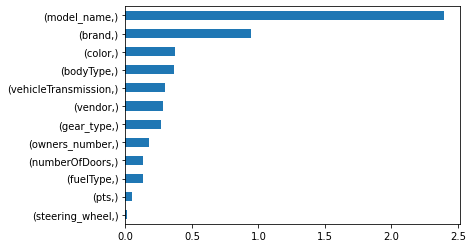

In [42]:
# посмотрим значимость признаков (категориальные + бинарные)

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

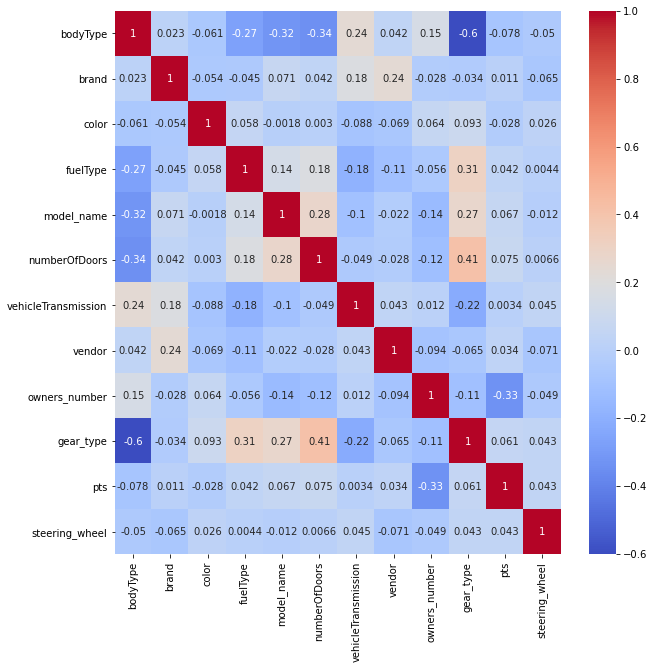

In [43]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[cat_cols + bin_cols].corr(method='spearman'), 
                 annot=True, cmap='coolwarm')

Мы видим, что модель автомобиля оказывает подавляющее влияние на стоимость автомобиля. Менее всего оригинальность ПТС и ориентация руля. Возможно, мы сможем создать дополнительные признаки на основании имеющихся, и попробуем помочь модели в прогнозировании, сделав акцент на признаки, больше всего влияющие на целевую переменную. Мы видим корреляцию между моделью автомобиля и кол-ом дверей / приводом. Привод также хорошо скоррелирован с типом кузов и кол-ом дверей соответственно. На основании указанных выше признаков можно будет попробовать собрать новый признак и посмотреть, как это скажется на качестве модели.

### num_cols

In [44]:
num_inspector = NumericInspector(data)

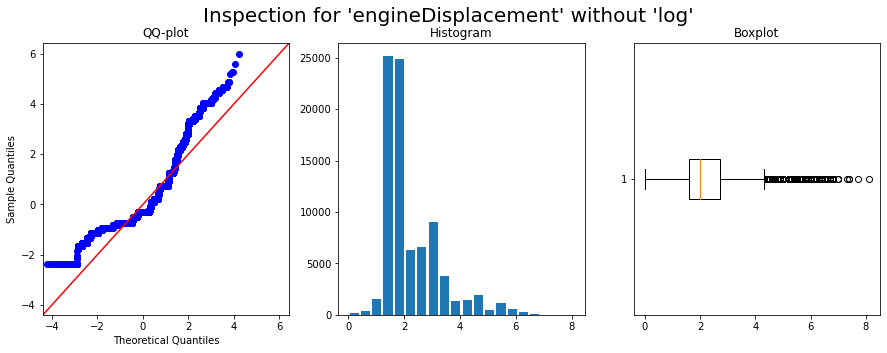

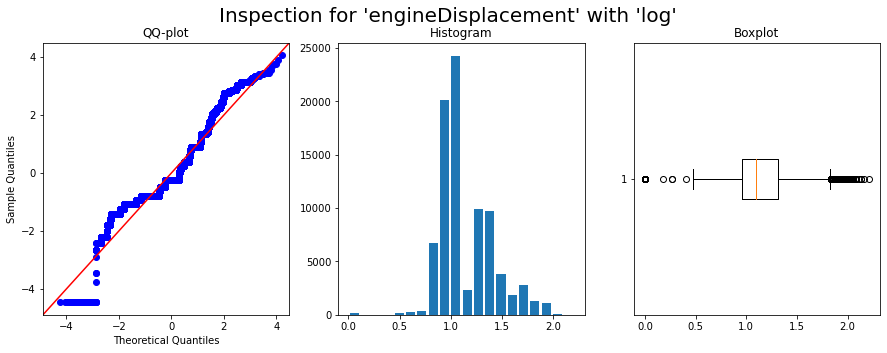

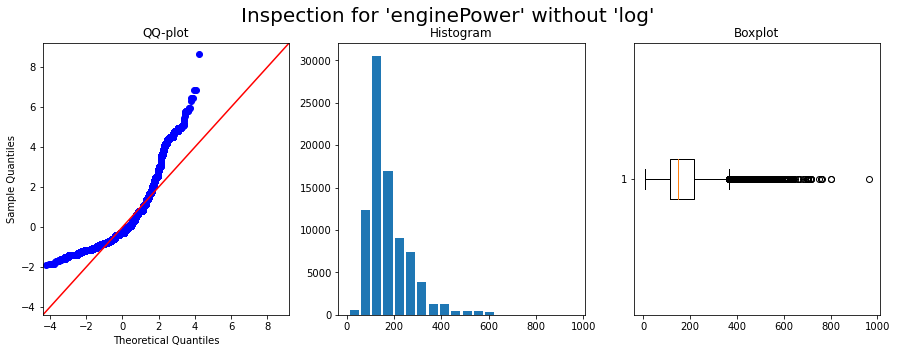

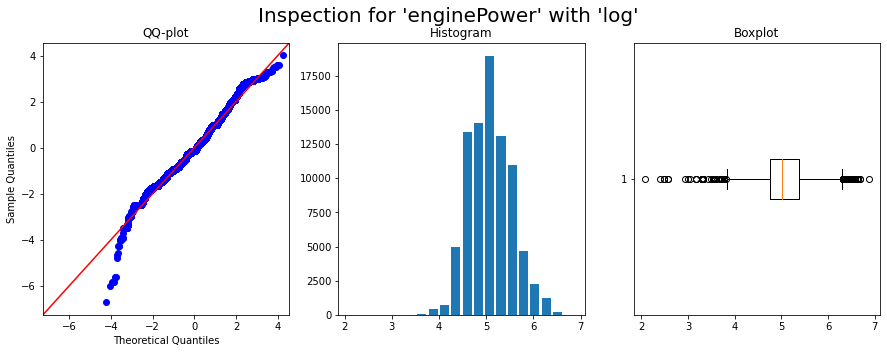

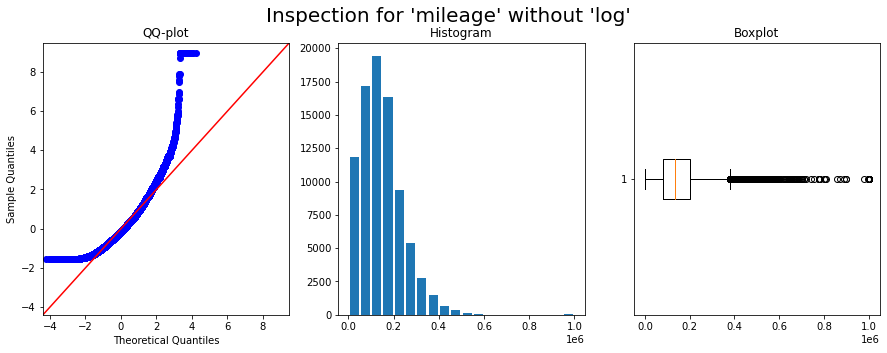

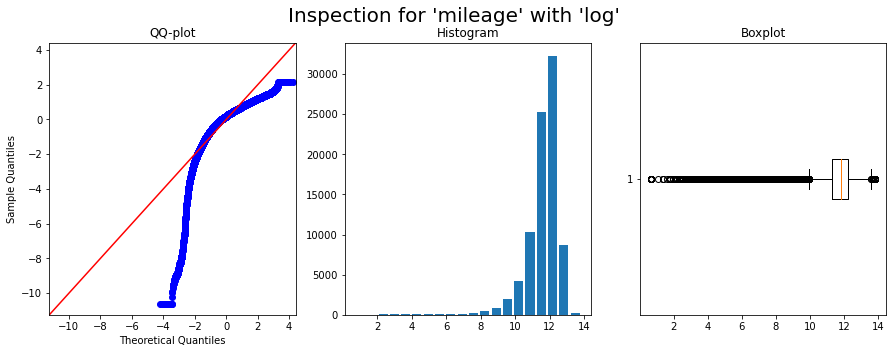

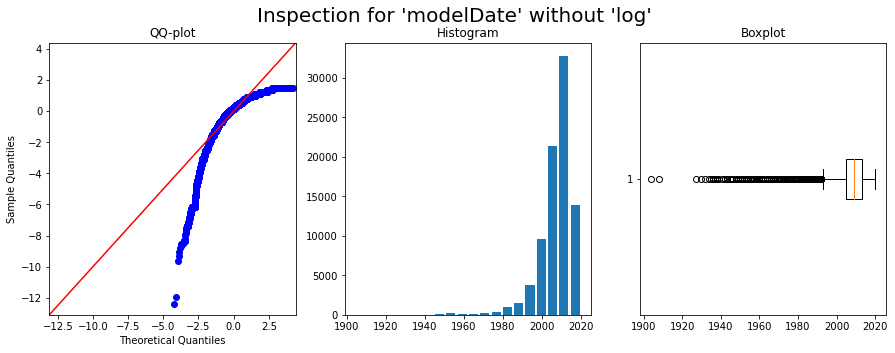

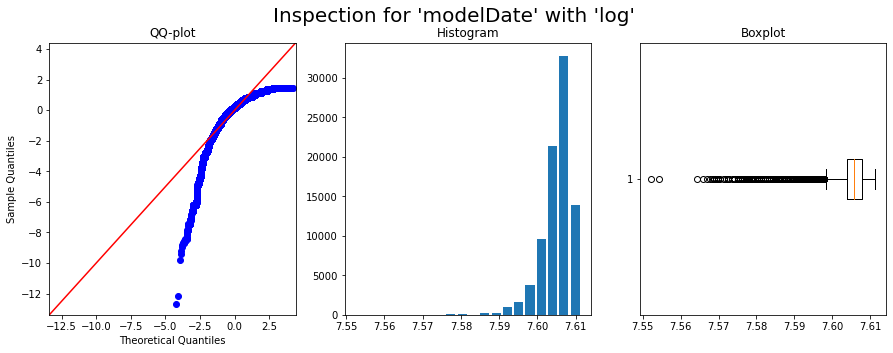

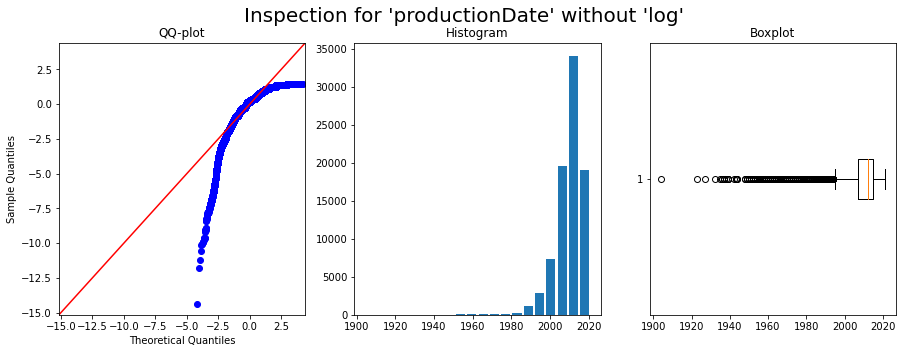

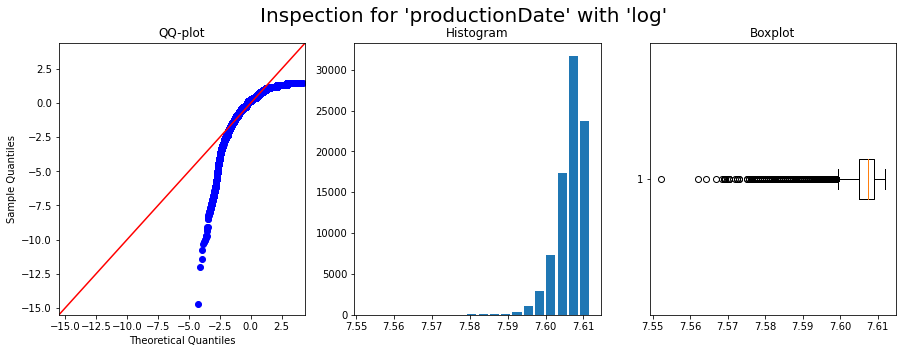

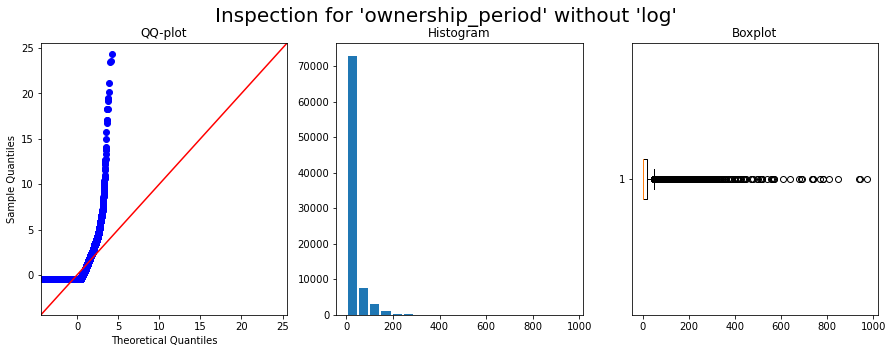

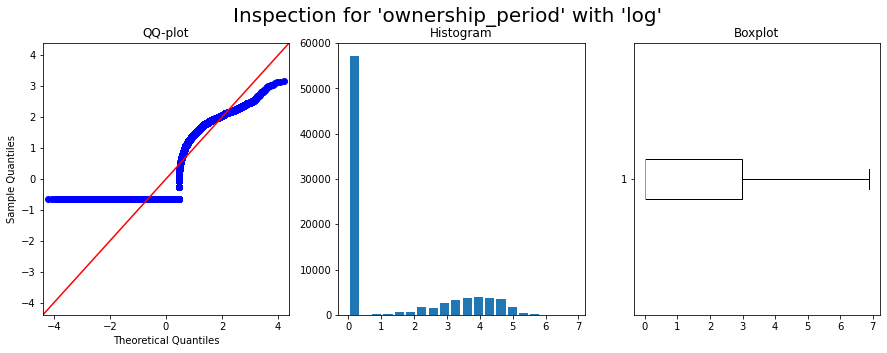

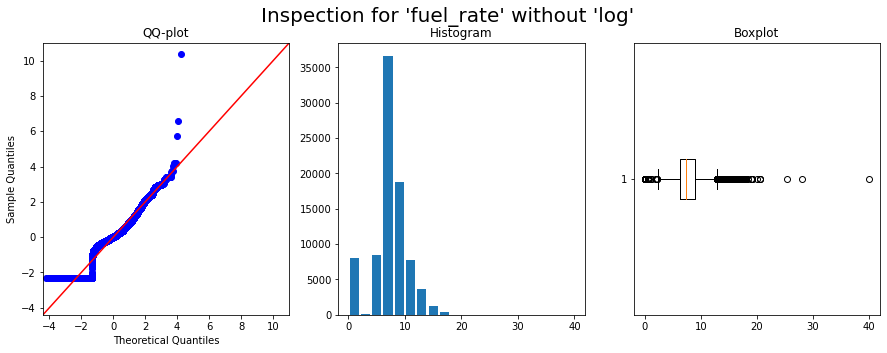

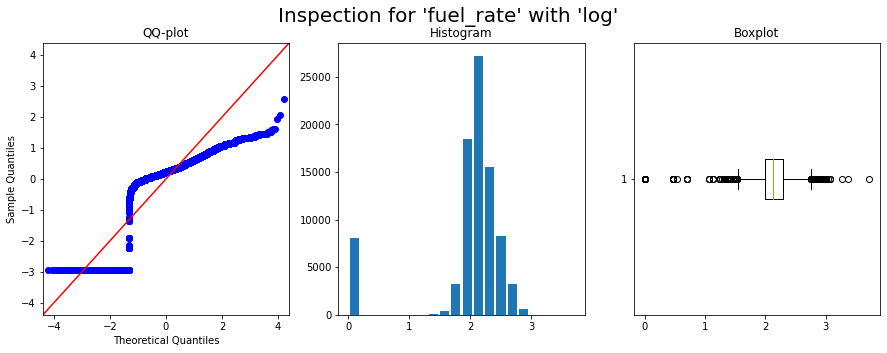

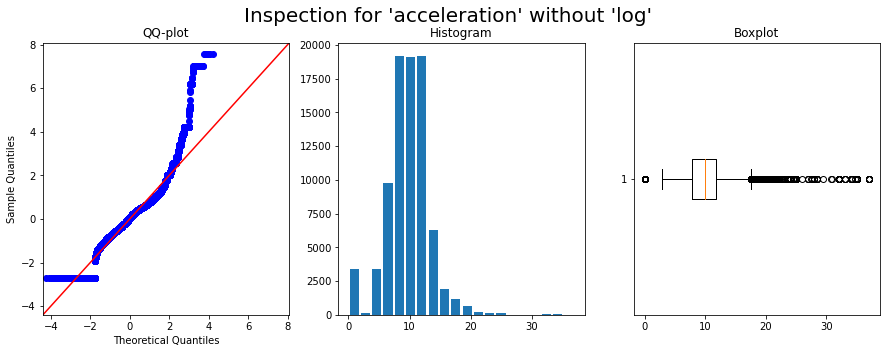

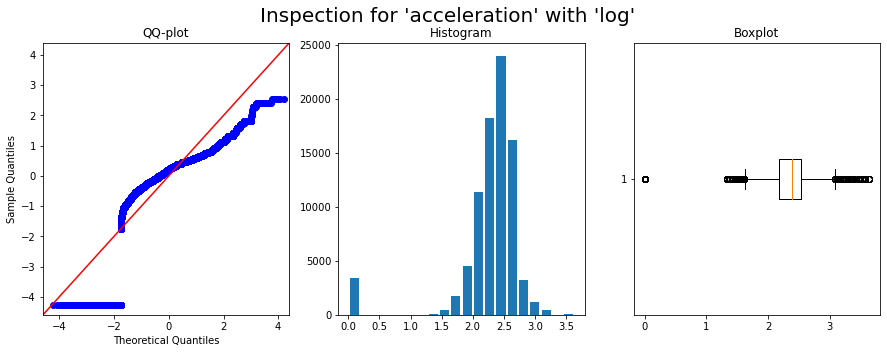

In [45]:
for col in num_cols:
    num_inspector.inspect(col)

#### ['engineDisplacement']

In [46]:
# посмотрим, сколько у нас нулевых значений

len(data[data['engineDisplacement'] == 0])

166

In [47]:
data['engineDisplacement'].describe()

count    84969.000000
mean         2.294994
std          0.965298
min          0.000000
25%          1.600000
50%          2.000000
75%          2.700000
max          8.100000
Name: engineDisplacement, dtype: float64

In [48]:
len(data.query('engineDisplacement >= 4.35'))

5195

Создадим категориальный признак, признак электрокара, а также избавимся от выбросов.

In [49]:
data['is_electro'] = data['engineDisplacement'].apply(lambda x: 1 if x == 0 else 0)

Создадим категориальный признак объема двигателя.

In [50]:
data['engineDisplacement_cat'] = data['engineDisplacement'].apply(lambda x: 1 if 0 <= x <=1.1 else 2 if 1.2 <= x <= 1.7
                                                                 else 3 if 1.8 <= x <= 3.5 else 4)

In [51]:
# работа с выбросами

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 4.35 if x >= 4.35 else x)

Логарифмируем данные.

In [52]:
data['engineDisplacement'] = np.log(data['engineDisplacement'] + 1)

Сделаем тоже самое еще с двуми признаками: мощность двигателя и пробег.

#### ['enginePower']

In [53]:
data['enginePower'].describe()

count    84969.000000
mean       177.937471
std         90.382270
min          7.000000
25%        115.000000
50%        150.000000
75%        215.000000
max        963.000000
Name: enginePower, dtype: float64

In [54]:
len(data.query('enginePower >= 365'))

4081

Создадим категориальный признак, избавимся от выбросов.

In [55]:
data['enginePower_cat'] = data['enginePower'].apply(lambda x: 1 if 0 <= x <= 70 else 2 if 71 <= x <= 100 
                                                    else 3 if 101 <= x <= 150 else 4 if 151 <= x <= 200
                                                   else 5)

In [56]:
# работа с выбросами

data['enginePower'] = data['enginePower'].apply(lambda x: 365 if x >= 365 else x)

Логарифмируем данные.

In [57]:
data['enginePower'] = np.log(data['enginePower'] + 1)

#### ['mileage']

In [58]:
data['mileage'].describe()

count      84969.000000
mean      148414.669338
std        95161.748672
min            1.000000
25%        80000.000000
50%       136000.000000
75%       199388.000000
max      1000000.000000
Name: mileage, dtype: float64

In [59]:
len(data.query('mileage >= 378470'))

1944

В этом признаке мы также наблюдаем большое кол-во выбросов. Создадим дополнительный категориальный признак пробега, логарифмировать не будем.

UPD: Экспериментально при построении модели было обнаружено, что избавление или сглаживания выбросов на этом конкретном признаке ухудшало качество модели, в отличие от других.

In [60]:
data['mileage_cat'] = data['mileage'].apply(lambda x: 1 if 0 <= x <= 100000 else 2 if 100001 <= x <= 300000 else 3)

#### ['modelDate'] / ['productionDate']

Эти два признака содержат выбросы, однако они имеют место быть. Логарифмирование не производим. Создадим дополнительные признаки старого производства / модели на основании нижней границы выбросов.

In [61]:
data['is_old_model'] = data['modelDate'].apply(lambda x: 1 if x <= 1993 else 0)

In [62]:
data['is_old_prod'] = data['productionDate'].apply(lambda x: 1 if x <= 1995 else 0)

#### ['ownership_period']

Признак времени владения. Более 60% имеют нулевые значения - это связано с пропусками в данных. Теоретически невозможно, чтобы автомобиль б/у находился до этого во владении 0 месяцев. Попробуем выделить нулевые значения в отдельный признак - period_unknown, а нулевые значения в исходном признаке заменить на медианные. Экспериментально оценим, как это окажет влияние на модель или нет. И если да - то в какую сторону. 

In [63]:
len(data.query('ownership_period == 0'))

57190

In [64]:
data['period_unknown'] = data.ownership_period.apply(lambda x: 1 if x == 0 else 0)

In [65]:
# преобразуем нули в пропуски, чтобы оценить распределение

data.ownership_period = data.ownership_period.apply(lambda x: None if x == 0 else x)

In [66]:
data.ownership_period.describe()

count    27779.000000
mean        55.333633
std         51.336454
min          1.000000
25%         20.000000
50%         41.000000
75%         78.000000
max        971.000000
Name: ownership_period, dtype: float64

Заменим пропуски на медианное значение.

In [67]:
data.ownership_period = data.ownership_period.fillna(41)

Логарифмируем данные.

In [68]:
data['ownership_period'] = np.log(data['ownership_period'] + 1)

#### ['fuel_rate'] / ['acceleration']

In [69]:
data.query('fuel_rate == 0').sample(10)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,ownership_period,pts,gear_type,steering_wheel,sample,price,fuel_rate,acceleration,is_electro,engineDisplacement_cat,enginePower_cat,mileage_cat,is_old_model,is_old_prod,period_unknown
79972,11,118,4,None,"Ваз 2103 1983 года, владею 4 года соответствен...",0.832909,4.248495,{'lock': True},0,70000,1972,42,4,1983,1102335105,2,5,3,3.737670,1,0,1,1,75000.0,0.0,21.0,0,2,1,1,1,1,1
67955,2,87,12,None,Кубик в отличном состоянии. Весь обслужен:заме...,0.916291,4.700480,"{'engine-proof': True, 'tinted-glass': True, '...",0,137000,2008,426,5,2012,1103277722,1,3,3,1.945910,1,1,0,1,530000.0,0.0,11.8,0,2,3,2,0,0,0
64026,2,84,11,None,"Авто в рабочем состоянии. Есть «жучьки», но в ...",1.223775,5.111988,{},0,300000,1997,346,5,2000,1101586664,0,3,2,3.737670,1,2,0,1,190000.0,0.0,0.0,0,3,4,2,0,0,1
78312,11,115,3,None,"Много что сделано, все вопросы по телефону или...",1.098612,4.663439,{},0,131000,1980,813,4,1981,1101892822,2,3,2,3.737670,1,0,0,1,265000.0,0.0,0.0,0,3,3,2,1,1,1
86737,0,129,15,None,Продажа от официального дилера ГК «АВТОМИР».\n...,0.916291,5.010635,{},0,94400,2013,1188,5,2017,1102856804,2,1,1,3.737670,1,1,1,1,615000.0,0.0,9.8,0,2,3,1,0,0,1
7040,11,120,4,None,"Продаю очень надёжный автомобиль. Двигатель, к...",1.223775,4.948760,"{'cruise-control': True, 'tinted-glass': True,...",0,303928,2004,1055,4,2007,1100318278,0,2,3,3.951244,0,1,1,0,NaN,0.0,10.6,0,3,3,3,0,0,0
16212,11,80,11,None,E500 95год. Внешний вид дорест. Технически пол...,1.677097,5.771441,None,0,200000,1992,535,4,1995,1096867504,0,2,3,3.737670,0,0,1,0,NaN,0.0,6.1,0,4,5,2,1,1,1
22028,0,115,12,None,Салон: 2. Безопасность: 1. Комфорт: 2. Защита ...,1.098612,4.912655,"{'tinted-glass': True, 'abs': True, 'wheel-con...",0,277335,1994,1014,5,1996,1099546058,0,3,3,3.737670,0,2,1,0,NaN,0.0,12.1,0,3,3,2,0,0,1
45280,8,42,1,None,привезен в рф в 2002.\nотработал 5 лет в скоро...,1.677097,5.198497,{},3,70000,1975,489,4,1989,1102227468,0,0,3,1.791759,0,0,1,1,190000.0,0.0,0.0,0,4,4,1,1,1,0
81726,18,118,11,None,"Бодрая рабочая лошадка. Масло не ест не дымит,...",0.916291,4.369448,{},0,100000,1987,48,5,2002,1102228830,2,5,3,3.737670,0,1,1,1,45000.0,0.0,12.5,0,2,2,1,1,0,1


Судя по данным, нулевое значение расхода на связано с принадлежностью к эектрокарам. В таком случае - это пропуски. Попробуем их заполнить медианой.

In [70]:
data.fuel_rate.describe()

count    84969.000000
mean         7.326574
std          3.151901
min          0.000000
25%          6.300000
50%          7.400000
75%          8.900000
max         40.000000
Name: fuel_rate, dtype: float64

In [71]:
data.acceleration.describe()

count    84969.000000
mean         9.762716
std          3.603004
min          0.000000
25%          7.800000
50%          9.900000
75%         11.700000
max         37.000000
Name: acceleration, dtype: float64

In [72]:
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 7.4 if x == 0 else x)

In [73]:
# работа с выбросами

data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 3.4 if x <= 3.4 else x)
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 12.8 if x >= 12.8 else x)

In [74]:
data['fuel_rate'] = np.log(data['fuel_rate'] + 1)

UPD: экспериментально, наряду с признаком пробега, было отмечено ухудшение показателей при удалении выбросов у признака ускорения.

In [75]:
data['acceleration'] = data['acceleration'].apply(lambda x: 9.9 if x == 0 else x)

In [76]:
data['acceleration'] = np.log(data['acceleration'] + 1)

In [77]:
# выделим часть train и посмотрим значимость признаков

train_data = data.query('sample == 1').drop(['sample'], axis=1)

In [78]:
cat_cols.extend(['engineDisplacement_cat', 'enginePower_cat', 'mileage_cat'])
bin_cols.extend(['is_electro', 'period_unknown'])

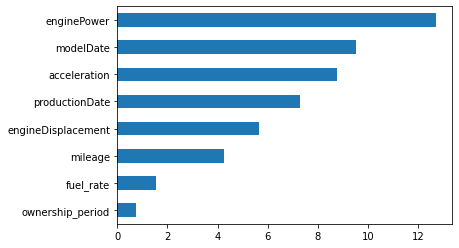

In [79]:
# посмотрим значимость признаков

imp_num = Series(f_classif(train_data[num_cols], train_data['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

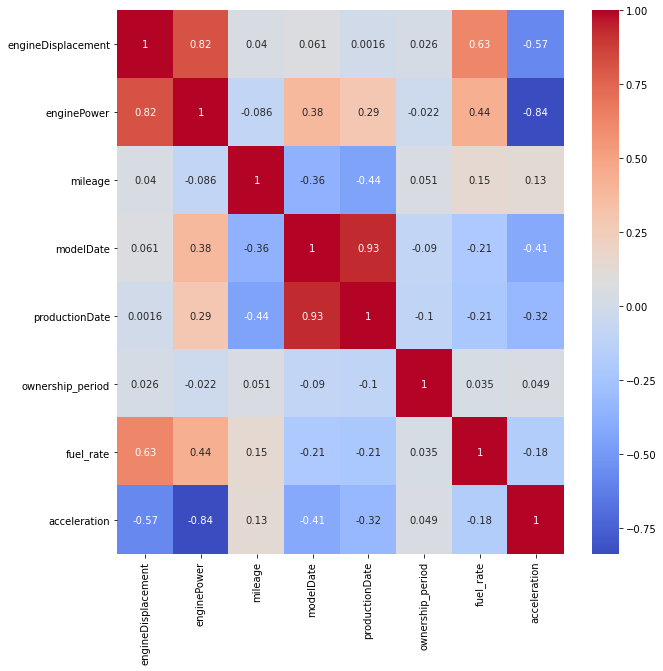

In [80]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[num_cols].corr(), 
                 annot=True, cmap='coolwarm')

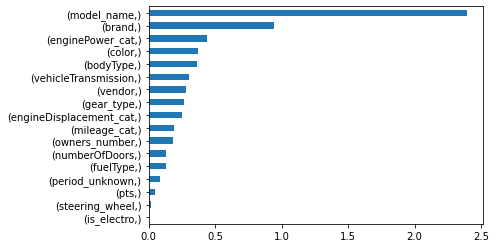

In [81]:
# посмотрим значимость признаков с учетом добавленных категориальных

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

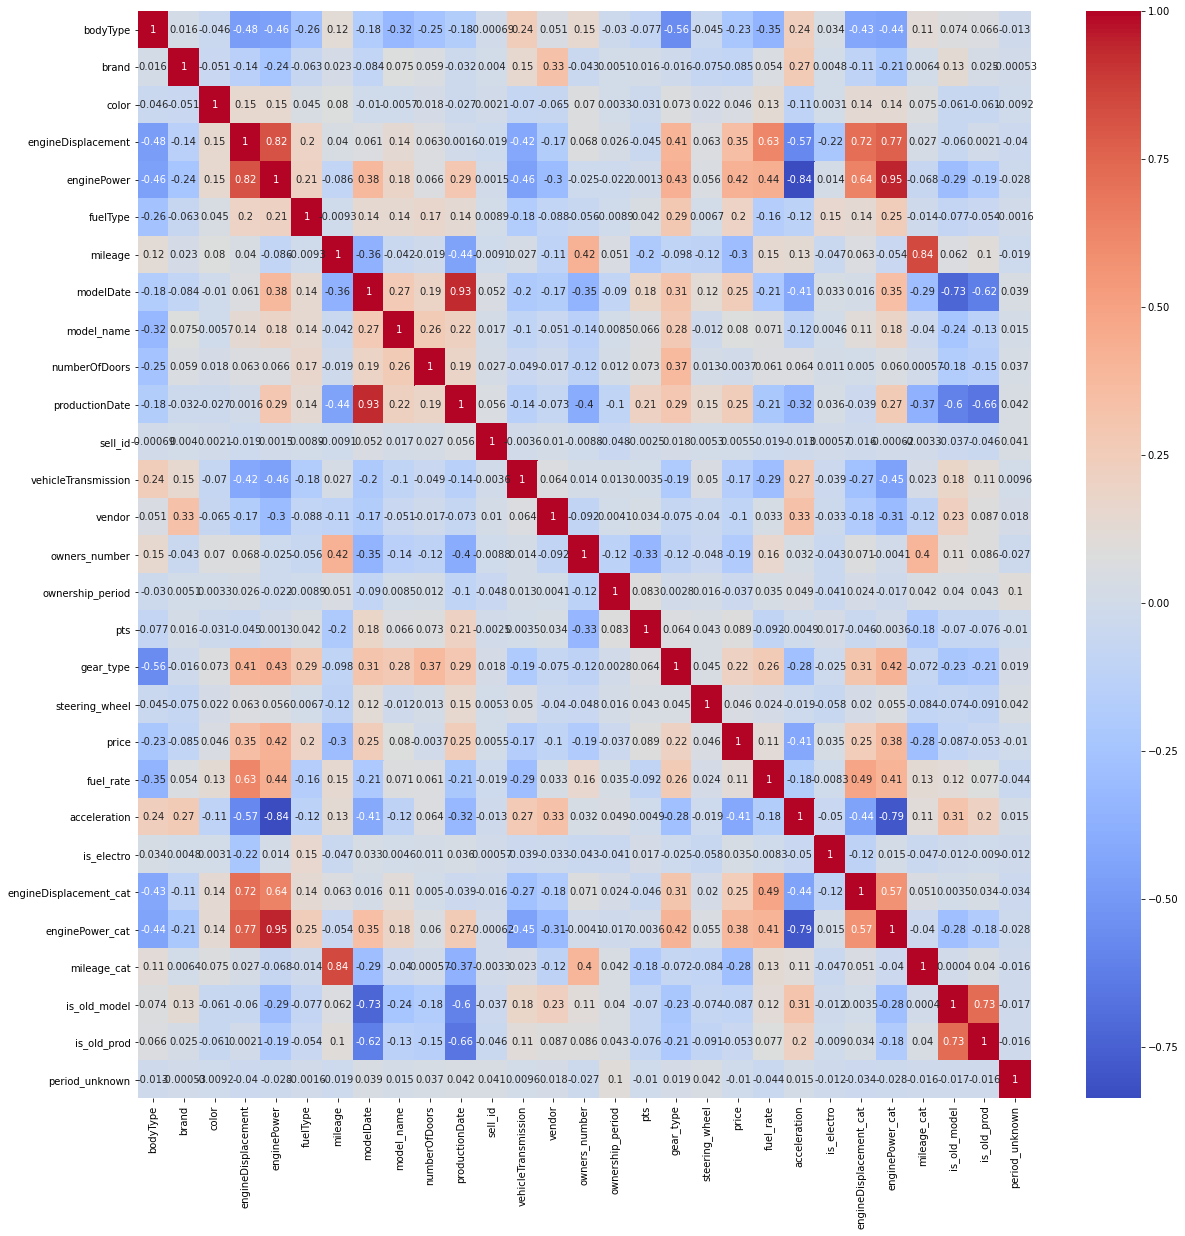

In [82]:
# Посмотрим общую корреляцию
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(train_data.corr(), 
                 annot=True, cmap='coolwarm')

In [83]:
# создадим новый признак на основании тех, что зависимы между собой и с целевой переменной

data['body_model_door_gear'] = (data['bodyType'] + data['model_name']) * data['gear_type'] + (2*data['numberOfDoors'])

### ['description']

В рамках обработки признака описания были выделены самые часто используемые слова и экспериментальным методом добавлен бинарный признак наличия слова в описании, улучшающий искомую метрику.

In [84]:
# преобразуем в нижний регистр, заполним пропуски
data.description = data.description.apply(lambda x: x.lower() if type(x) == str else x)
data.description = data.description.fillna('ничего')

# проанализируем, выделив слова 
analyzer = CountVectorizer().build_analyzer()
docs = []
for document in data.description:
    docs.append(analyzer(document))

# соберем слова в единый список, отфильтров короткие (чаще - предлоги, союзы)
all_words = []
for i in docs:
    for x in i:
        if len(x) > 3:
            all_words.append(x)
            
            
c = collections.Counter() # Введем переменную для подсчета объектов с помощью модуля collections.

# Пройдемся циклом и подсчитаем количество значений для каждого слова. Посмотрим самые часто встречающиеся
for i in all_words:
    c[i] += 1
print(c.most_common(50))

[('автомобиль', 69550), ('автомобиля', 60009), ('пробегом', 49389), ('система', 44050), ('автомобилей', 32965), ('автомобили', 30555), ('состоянии', 29779), ('более', 27857), ('кредит', 27649), ('авто', 26428), ('есть', 23865), ('салон', 23838), ('машина', 23584), ('вашего', 21034), ('безопасности', 20364), ('сидений', 19361), ('комплектация', 18904), ('руля', 18583), ('торг', 17458), ('обогрев', 17259), ('зеркал', 17218), ('водителя', 17137), ('года', 17113), ('день', 16824), ('комплект', 16798), ('покупке', 16707), ('салона', 16693), ('контроль', 16657), ('передние', 16533), ('пробег', 16211), ('только', 16024), ('диски', 16005), ('подушки', 15845), ('рольф', 15567), ('дилера', 15291), ('юридической', 15270), ('фары', 15109), ('обслуживание', 14956), ('чистоты', 14122), ('датчик', 14003), ('официального', 13943), ('оригинал', 13822), ('подогрев', 13684), ('обмен', 13350), ('каско', 13304), ('пассажира', 13297), ('гарантия', 12911), ('кредита', 12584), ('рублей', 12459), ('отличном', 

In [85]:
# добавим новый признак
data['word_каско'] = data['description'].apply(lambda x: 1 if 'каско' in x else 0)

# Выводы

- Представленные выше графики построены для разведывательного анализа данных. Мы видим, что на цену автомобиля больше всего влияют следующие признаки: объем двигателя, его мощность, пробег, разгон, год производства. Название модели и тип топлива также важны для цены. Между model_date и production_date существует сильная корреляция - один из признаков, вероятно, будет убран.
- Чтобы отслеживать, насколько то или иное дальнейшее изменение полезно для модели, построим изначально наивную модель и посмотрим метрику mape.
- На основании проведенного выше анализа данных, предлагается далее провести эксперименты с данными (отбор признаков, эксперименты со сглаживанием выбросов, добавление новых на основании имеющихся), опираясь на изменения в метриках модели.
- Далее необходимо построить модели с учетом подбора гиперпараметров, отбором признаков и стекингом.
- При построении модели, вероятно, будет необходимо делать логарифмирование целевой переменной.

# Naive model

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [86]:
train_data = data.query('sample == 1').drop(['sample', 'complectation_dict', 'description', 'equipment_dict'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [88]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [89]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 98.27%


# Model experiments

В рамках дальнейшей работы были проведены эксперименты с построением следующих моделей:
- Linear Regression
- Random Forest Regressor
- Extra Trees Regressor
- Decision Tree Regressor
- Kneigbors
- AdaBoost
- GradientBoosting
- XGBoost
- CatBoost

В финальном ноутбуке эксперименты не отражены для оптимизации рабочего пространства.
Наилучшие результаты показали:
- Random Forest, Extra Trees, XGBoost, CatBoost

Также были проведены эксперименты с разной стандартизацией признаков. Оптимальным оказался выбор StandardScaler.
Дополнительно были проведены эксперименты с введением новых признаков, включая полиноминальные. Однако это ухудшило качество модели, поэтому было принято решение отказаться от данных признаков и не указывать их в финальном ноутбуке.

# Stacking

В рамках стекинга были проведены эксперименты по подбору моделей estimators (до 4 estimators) и мета-модели с разными параметрами, порядком и т.д.
Наилучшие результаты показал указанный ниже стекинг.

Дополнительно был проведен отбор признаков. Был испробован метод отбора признаков с помощью SelectKBest, однако ручной отбор показал лучшие результаты.

In [90]:
# избавимся от лишнего
train_data = data.query('sample == 1').drop(['sample', 'complectation_dict', 'description', 
                                             'equipment_dict', 'productionDate', 'is_old_model',
                                            'engineDisplacement_cat', 'vehicleTransmission'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# проведем стандартизацию
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [91]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

## Поиск наилучших параметров для моделей

С помощью RandomizedSearchCV был произведен подбор параметров. Однако в дальнейшем параметры немного корректировались вручную. Что улучшило результат по метрике.

In [92]:
# # Поиск лучших параметров для CatBoostRegressor (поиск занимает очень большой промежуток времени)

# model = CatBoostRegressor(
#     random_seed=RANDOM_SEED,
#     eval_metric='MAPE',
#     custom_metric=['MAE'],
#     silent=True,
#     task_type='GPU'
# )

# grid = {
#     'learning_rate': [0.03, 0.05, 0.1],
#     'depth': [2, 4, 6],
#     'l2_leaf_reg': [1, 3, 5, 7, 9],
#     'iterations': [int(x) for x in np.linspace(start=1000, stop=5000, num=20)]
# } 

# grid_search_result = model.grid_search(
#     grid,
#     X=X_train_st,
#     y=np.log(y_train),
#     plot=True
# )

In [93]:
# Общий метод для SkLearn регрессоров

def find_best_params(estimator, parameters, x_train, y_train):
    grid = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=parameters,
        random_state=RANDOM_SEED,
        n_iter=100,
        verbose=10,
        n_jobs=2
    )

    grid.fit(x_train, y_train)
    
    print("Best params:", grid.best_params_)
    print("Best score:", grid.best_score_)

In [94]:
# # Поиск лучших параметров для XGBRegressor (поиск занимает очень большой промежуток времени)

# find_best_params(
#     estimator=xgb.XGBRegressor(colsample_bytree=0.5, alpha=1),
#     parameters={
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [1, 3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'objective': ['reg:squarederror'],
#         'n_estimators': [int(x) for x in np.linspace(start=1000, stop=2000, num=5)]
#     },
#     x_train=X_train_st,
#     y_train=np.log(y_train)
# )

## Финальное обучение

In [95]:
estimators = [
    ('cat_boost', CatBoostRegressor(
        random_seed=RANDOM_SEED,
        eval_metric='MAPE',
        iterations=4200,
        l2_leaf_reg=4,
        depth=7,
        custom_metric=['MAE'],
        loss_function='RMSE',
        learning_rate=0.08,
        verbose=1
    ))
]

reg = StackingRegressor(
    estimators=estimators,
    cv=cv,
    verbose=10,
    passthrough=True,
    n_jobs=-1,
    final_estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.5,
        learning_rate=0.03,
        max_depth=11,
        alpha=1,
        n_jobs=-1,
        n_estimators=1200,
        seed=RANDOM_SEED
    )
)

reg.fit(X_train_st, np.log(y_train))
y_pred = np.exp(reg.predict(X_test_st))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 15.91%


# Итог:
В результате работы над данными:
- был произведен парсинг данных с auto.ru 
- был произведен разведывательный анализ данных
- созданы новые признаки
- отбраны признаки для модели по значимости
- произведены эксперименты по подбору модели
- произведены эксперименты по стекингу
- подобраны оптимальные гиперпараметры для модели


## Вывод:
В результате преобразований и в сравнении с наивной моделью мы видим значительные улучшения предсказательной способности нашей модели. 

# Submission

In [96]:
X_sub = data.query('sample == 0').drop(['sample', 'complectation_dict', 'description', 
                                             'equipment_dict', 'productionDate', 'is_old_model',
                                            'engineDisplacement_cat', 'vehicleTransmission', 'price'], axis=1)

In [97]:
X_sub = scaler.transform(X_sub)

Так как данные для тестовой выборки собраны раньше, чем для обучающей. За это время изменился рынок цен. Экспериментально был подобран коэффициент 0,88.

In [98]:
predict_submission = np.exp(reg.predict(X_sub))*0.88

In [99]:
sample_submission = pd.read_csv('sample_submission.csv')

In [100]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.710101e+05
1,1100549428,8.898148e+05
2,1100658222,8.687878e+05
3,1100937408,8.526139e+05
4,1101037972,6.555072e+05
5,1100912634,5.762338e+05
6,1101228730,6.329126e+05
7,1100165896,4.215712e+05
8,1100768262,1.952018e+06
9,1101218501,7.600581e+05
